In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as appl
from sklearn.model_selection import train_test_split
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from keras import callbacks  
from keras.models import load_model
from keras.utils import np_utils

In [2]:
load_path='D:/VA/onehandtwohand/128/105words_DSLR_results/'

In [3]:
CATEGORIES=np.load(load_path+'cat_105.npy', allow_pickle=True)

In [4]:
# CATEGORIES=['antelope', 'bag', 'book', 'bottle', 'colour', 'dolphin', 'dupatta', 'fast', 'fish', 'frog', 'gun',
#             'hair', 'help', 'idea', 'internet', 'jeans', 'location', 'owl', 'pen', 'photo', 'rain', 'saree', 'school',
#             'shoot', 'sun', 'technology', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'
#             , 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'accept', 'age', 'assistant', 'black', 'boot', 'card', 'cash',
#             'chicken', 'dance', 'earpods', 'handkerchief', 'home', 'human', 'keep', 'laptop', 'meet', 'mobile', 'monkey',
#             'namastey', 'person', 'proof', 'signature', 'sleep', 'spider', 'stand', 'star', 'tv', 'umbrella', 'white',
#             'wolf', 'yellow']

In [5]:
# # get categories in dataset
# TRAIN_DIR = "D:/VA/25words_DSLR"
# CATEGORIES = []
# for img in tqdm(os.listdir(TRAIN_DIR)):
#     CATEGORIES.append(img)
# TRAIN_DIR = "D:/VA/26words_DSLR"
# for img in tqdm(os.listdir(TRAIN_DIR)):
#     CATEGORIES.append(img)

# TRAIN_DIR = "D:/VA/31words_DSLR"
# for img in tqdm(os.listdir(TRAIN_DIR)):
#     CATEGORIES.append(img)

#     # exclude situation
# npys=['X.npy','Y.npy','training.npy']
# from collections import Counter
# CATEGORIES = list((Counter(CATEGORIES)-Counter(npys)).elements())

# print(CATEGORIES)

In [6]:
IMG_SIZE=128

In [7]:
cat_len=len(CATEGORIES)
print(cat_len)

105


# Save combined data npy

In [9]:
# model

# model_name1 = 'InceptionResNetV2'
# model_name1 = '4layer'
model_name1 = 'densenet201pretrained_105words_dslr128'
#model_name2 = 'VGG16'
# model_name1 = 'DenseNet121'
# model_name1 = 'InceptionV3'

Loading

In [10]:
X=np.load(load_path+'X.npy', allow_pickle=True)
Y=np.load(load_path+'Y.npy', allow_pickle=True)

In [11]:
X = X.astype('float32')
X /= 255


In [12]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")

Splitting
pass


In [13]:
del X,Y

In [14]:
print('Image Data Augmentation')
from keras.preprocessing.image import ImageDataGenerator
val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2)
#                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
val_generator.fit(X_train)
val_generator.fit(X_new)
val_generator.fit(X_test)

print("done")

Image Data Augmentation
done


In [15]:
model_name1 = 'DenseNet201'

exec('from tensorflow.keras.applications import '+ model_name1)

#inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')

#exec('MODEL = '+model_name1+'(include_top=False, weights=\'imagenet\')')
exec('MODEL = '+model_name1+'(input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)), include_top=False, weights=\'imagenet\')')
# MODEL.trainable=False
# MODEL.summary()
for layers in MODEL.layers: 
    layers.trainable=False
input_layer = MODEL.output
x = Flatten(name='flatten')(input_layer)
fc1 = Dense(1024, activation='relu', name='fc1')(x)
fc2 = Dense(512, activation='relu', name='fc2')(fc1)
out = Dense(cat_len, activation='softmax', name='predictions')(fc2)
model1 = Model(inputs=MODEL.input, outputs=out)

model1.summary()

74836368/74836368 [==============================] - 42s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalizatio

In [16]:
print('Training model 1')
opt = Adam(learning_rate=0.0001)
earlystopping = callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
model1.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
# model1.summary()



history_const = model1.fit(X_train, y_train,batch_size=50, epochs = 1000, validation_data=(X_test,y_test),
                   callbacks= [earlystopping])


Training model 1
Epoch 1/1000
487/487 [==============================] - 38s 62ms/step - loss: 0.8847 - accuracy: 0.7926 - val_loss: 0.2714 - val_accuracy: 0.9286
Epoch 2/1000
487/487 [==============================] - 27s 56ms/step - loss: 0.1531 - accuracy: 0.9619 - val_loss: 0.1494 - val_accuracy: 0.9591
Epoch 3/1000
487/487 [==============================] - 27s 56ms/step - loss: 0.0834 - accuracy: 0.9789 - val_loss: 0.1051 - val_accuracy: 0.9725
Epoch 4/1000
487/487 [==============================] - 27s 56ms/step - loss: 0.0468 - accuracy: 0.9891 - val_loss: 0.0850 - val_accuracy: 0.9764
Epoch 5/1000
487/487 [==============================] - 27s 55ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.0981 - val_accuracy: 0.9714
Epoch 6/1000
487/487 [==============================] - 27s 56ms/step - loss: 0.0432 - accuracy: 0.9878 - val_loss: 0.1427 - val_accuracy: 0.9594
Epoch 7/1000
487/487 [==============================] - 27s 55ms/step - loss: 0.0320 - accuracy: 0.9915 - v

In [17]:
print('Saving')
np.save(load_path+model_name1+'_history.npy',history_const.history)
model1.save(load_path+model_name1+'_model.h5') 
print("saved")

Saving
saved


In [18]:
# # #load saved history
# history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()

# # #load saved model
# model1=load_model(load_path+model_name1+'_model.h5')

# print("loaded")

loaded


Plots


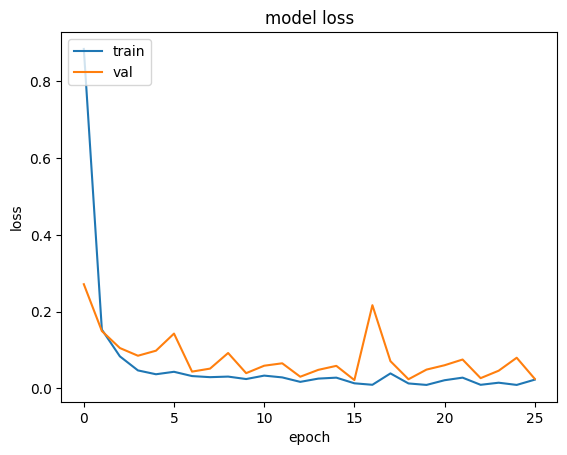

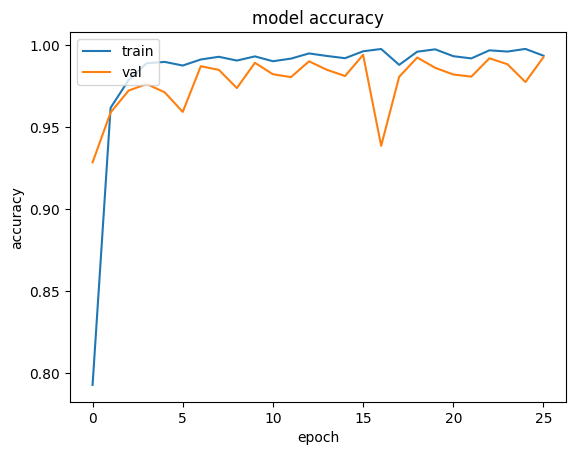

In [20]:
print('Plots')
plt.plot(history_const.history['loss'])
plt.plot(history_const.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('F:/VA/onehandtwohand/26words_DSLR_results/'+model_name1+'_loss.png')
plt.savefig(load_path+model_name1+'_loss.png')
plt.show()
plt.plot(history_const.history['accuracy'])
plt.plot(history_const.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(load_path+model_name1+'_accuracy.png')
plt.show()

In [21]:
print('Confusion matrix')
Y_pred = model1.predict(X_new)
y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new, axis=1)

cm=metrics.confusion_matrix(y_test1, y_pred)


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (200, 100)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig(load_path+model_name1+'_cm.png',bbox_inches='tight')
plt.show()


Confusion matrix
191/191 [==============================] - 7s 26ms/step


ValueError: The number of FixedLocator locations (97), usually from a call to set_ticks, does not match the number of ticklabels (105).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (83,) and arg 1 with shape (75,).

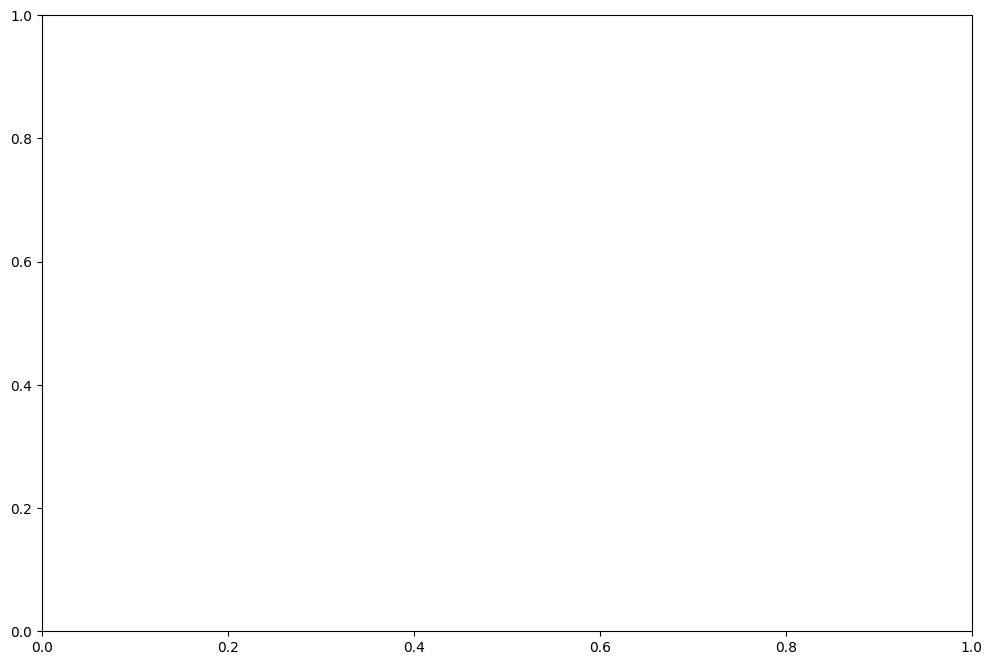

In [20]:
#PLot fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(np.arange(cat_len), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(cat_len), CATEGORIES)
plt.savefig(load_path+model_name1+'_incorrect_percentage.png',bbox_inches='tight')
plt.show()

In [ ]:
#CHECK RANDOM IMAGES FROM TESTED DATA WHETHER RIGHT OR WRONG

i = random.randint(1,cat_len)
plt.imshow(X_new[i,:,:,2]) 
print("Predicted Label: ", CATEGORIES[int(y_pred[i])])
print("True Label: ", CATEGORIES[int(y_test1[i])])

# Colourful mediapipe testing with VA_create_3.0

In [21]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
    
def draw_landmarks(image, results):   
    #face
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
#     #pose
#     mp_drawing.draw_landmarks(
#         image,
#         results.pose_landmarks,
#         mp_holistic.POSE_CONNECTIONS,
#         landmark_drawing_spec=mp_drawing_styles
#         .get_default_pose_landmarks_style())
    
    #left hand
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
#         landmark_drawing_spec=None,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # right hand
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
#         landmark_drawing_spec=None,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

In [24]:
## For veryyyyyyyy beautiful webcam input:

cap = cv2.VideoCapture(0)
org = (20, 20)  
org1 = (310, 20) 
fontScale = 0.65  
font = cv2.FONT_HERSHEY_SIMPLEX
# Blue color in BGR
color = (130, 0, 0)  
# Line thickness of 2 px
thickness = 1 
thickness1 = -1
start_point = (0,0)
end_point = (480,30)
color1 = (255, 255, 255)  

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
      while cap.isOpened():
        #image from feeder
        r, img_array = cap.read()
        img_array = cv2.flip(img_array, 1)
        img_array = img_array[:, 80:560, :]
        image, results = mediapipe_detection(img_array, holistic)
        draw_landmarks(image, results)
        if not (results.left_hand_landmarks or results.right_hand_landmarks):
            continue

        # white background
        img = np.zeros([480,480,3],dtype=np.uint8)
        img.fill(255) 
        draw_landmarks(img, results)

        # for prediction
        IMG_SIZE=128
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        X = X.astype('float32')
        X /= 255
        X = np.array(X)
        Y = model1.predict(X,verbose=0)

        if np.max(Y)>0.2:
            # for display
            image = cv2.rectangle(image, start_point, end_point, color1, thickness1)
            image = cv2.rectangle(image, (0,30), (480,30), color, 2)
            image = cv2.putText(image,"Prediction: "+ CATEGORIES[np.argmax(Y)], org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            image = cv2.putText(image,"Accuracy: "+ "%.2f" % np.max(Y), org1, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            if np.max(Y)>0.95:
                cv2.imwrite(load_path+'/test_images/'+CATEGORIES[np.argmax(Y)]+str(np.max(Y))+'.jpg',image)


        cv2.imshow('Realtime testing', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
                break
# close the camera
cap.release()

# close all the opened windows
cv2.destroyAllWindows()